In [50]:
using Symbolics

In [51]:
using Einsum

In [53]:
using LinearAlgebra

# Thermodynamically based derivation of material models in Julia

In [55]:
using Interact
using Plots

In [57]:
α = 5

5

In [59]:
α

5

In [56]:
@variables u_N;
u_N

u_N

In [62]:
𝒫 = @variables E_N S_N c_N K γ;

In [63]:
@variables uᵖ_N ω_N;
ℱᵥ = @variables σᵖ_N Y_N;
ℰ = [uᵖ_N, ω_N]
n_ℰ = length(ℰ)
ℱᵥ

2-element Vector{Num}:
 σᵖ_N
  Y_N

# Potential I: Helmholtz free energy

In [64]:
ρψ = (1 - ω_N) * E_N * (u_N - uᵖ_N)^2 / 2

(1//2)*E_N*((u_N - uᵖ_N)^2)*(1 - ω_N)

In [65]:
Υ = [-1, -1];

In [66]:
∂ρψ_∂ℰ = Symbolics.gradient(ρψ, ℰ)

2-element Vector{Num}:
  (1//2)*E_N*(2uᵖ_N - 2u_N)*(1 - ω_N)
 (-1//2)*E_N*((u_N - uᵖ_N)^2)

In [67]:
ℱ = Array(Υ .* ∂ρψ_∂ℰ)
ℱ #, typeof(ℱ)

2-element Vector{Num}:
 (-1//2)*E_N*(2uᵖ_N - 2u_N)*(1 - ω_N)
  (1//2)*E_N*((u_N - uᵖ_N)^2)

In [17]:
δᵢⱼ = Matrix(I, n_ℰ, n_ℰ);

In [18]:
length(ℰ)

2

In [68]:
@einsum ℱ[i] := δᵢⱼ[i, j] * Υ[j] * ∂ρψ_∂ℰ[j] 

2-element Vector{Num}:
 (-1//2)*E_N*(2uᵖ_N - 2u_N)*(1 - ω_N)
  (1//2)*E_N*((u_N - uᵖ_N)^2)

In [70]:
∂ℱ_∂ℰ = Symbolics.jacobian(ℱ, ℰ)

2×2 Matrix{Num}:
       -E_N*(1 - ω_N)       (1//2)*E_N*(2uᵖ_N - 2u_N)
 (1//2)*E_N*(2uᵖ_N - 2u_N)        0

In [71]:
Symbolics.sparsejacobian(ℱ, ℰ)

2×2 SparseArrays.SparseMatrixCSC{Num, Int64} with 3 stored entries:
       -E_N*(1 - ω_N)       (1//2)*E_N*(2uᵖ_N - 2u_N)
 (1//2)*E_N*(2uᵖ_N - 2u_N)        ⋅

In [49]:
get_Eps = Symbolics.build_function(E_N, E_N, conv=True );

LoadError: UndefVarError: True not defined

In [48]:
get_Eps(10)

LoadError: MethodError: objects of type Expr are not callable

In [31]:
get_Sig_Eps = Symbolics.build_function.(ℱ', [ℰ, E_N, S_N, c_N, K, γ] );

In [32]:
get_Sig_Eps([0.2 0.1 0.3], 1000., 1e-3, 1., 0.0, 0.0)

LoadError: MethodError: objects of type Matrix{Expr} are not callable
Use square brackets [] for indexing an Array.

In [19]:
get_Eps = lambdify.(ℰ, (ℰ,))

2-element Vector{SymPy.var"#118#119"}:
 #118 (generic function with 1 method)
 #118 (generic function with 1 method)

In [20]:
get_Eps[1](0,1)

0

In [21]:
get_Sig_Eps.([0.2 0.1 0.3], 1000., 1e-3, 1., 0.0, 0.0)

LoadError: UndefVarError: get_Sig_Eps not defined

# Potential II: Threshold function

In [28]:
@vars x
@vars y
@vars x_c
@vars a b nonnegative=True
@vars c positive=True
x, y, x_c, a, b, c

(x, y, x_c, a, b, c)

In [29]:
@vars x_0 
@vars x_bar y_bar nonnegative=True
@vars m nonnegative=True

(m,)

In [30]:
f_lin_ = sqrt(y^2) - (y_bar - m * (x-x_0))

                        ____
                       ╱  2 
m⋅(x - x₀) - y_bar + ╲╱  y  

In [31]:
f_ell_ = sqrt((x-x_0-x_c)^2/a^2 + y^2/b^2) - c
f_ell_

           ______________________
          ╱  2                 2 
         ╱  y    (x - x₀ - x_c)  
-c +    ╱   ── + ─────────────── 
       ╱     2           2       
     ╲╱     b           a        

In [32]:
∂f_ell_∂x = f_ell_.diff(x);
∂f_ell_∂y = f_ell_.diff(y);

In [33]:
eq1 = Eq(subs(f_ell_, (x, x_bar), (y, 0)), 0)
eq2 = Eq(subs(f_ell_, (x, x_0), (y, y_bar)), 0)
eq3 = Eq(subs((-∂f_ell_∂x / ∂f_ell_∂y), (x, x_0), (y, y_bar)), -m)
eq3

  2          
 b ⋅x_c      
──────── = -m
 2           
a ⋅y_bar     

In [34]:
sol1, sol2, sol3, sol4 = sympy.solve((eq1, eq2, eq3),(a, b, x_c))

4-element Vector{Tuple{Sym, Sym, Sym}}:
 (-(x_0 - x_bar)*(m*x_0 - m*x_bar + y_bar)/(c*(2*m*x_0 - 2*m*x_bar + y_bar)), sqrt(y_bar)*(-m*x_0 + m*x_bar - y_bar)*sqrt(1/(2*m*x_0 - 2*m*x_bar + y_bar))/c, m*(-x_0^2 + 2*x_0*x_bar - x_bar^2)/(2*m*x_0 - 2*m*x_bar + y_bar))
 (-(x_0 - x_bar)*(m*x_0 - m*x_bar + y_bar)/(c*(2*m*x_0 - 2*m*x_bar + y_bar)), sqrt(y_bar)*(m*x_0 - m*x_bar + y_bar)*sqrt(1/(2*m*x_0 - 2*m*x_bar + y_bar))/c, m*(-x_0^2 + 2*x_0*x_bar - x_bar^2)/(2*m*x_0 - 2*m*x_bar + y_bar))
 ((x_0 - x_bar)*(m*x_0 - m*x_bar + y_bar)/(c*(2*m*x_0 - 2*m*x_bar + y_bar)), sqrt(y_bar)*(-m*x_0 + m*x_bar - y_bar)*sqrt(1/(2*m*x_0 - 2*m*x_bar + y_bar))/c, m*(-x_0^2 + 2*x_0*x_bar - x_bar^2)/(2*m*x_0 - 2*m*x_bar + y_bar))
 ((x_0 - x_bar)*(m*x_0 - m*x_bar + y_bar)/(c*(2*m*x_0 - 2*m*x_bar + y_bar)), sqrt(y_bar)*(m*x_0 - m*x_bar + y_bar)*sqrt(1/(2*m*x_0 - 2*m*x_bar + y_bar))/c, m*(-x_0^2 + 2*x_0*x_bar - x_bar^2)/(2*m*x_0 - 2*m*x_bar + y_bar))

In [35]:
sol2[2]

                                       ____________________________
  _______                             ╱             1              
╲╱ y_bar ⋅(m⋅x₀ - m⋅x_bar + y_bar)⋅  ╱  ────────────────────────── 
                                   ╲╱   2⋅m⋅x₀ - 2⋅m⋅x_bar + y_bar 
───────────────────────────────────────────────────────────────────
                                 c                                 

In [36]:
abx_subs = sympy.solve([eq1 eq2 eq3],[a, b, x_c])[2]
a_, b_, x_c_ = abx_subs
subs_abx = Dict(a => a_, b => b_, x_c => x_c_)

/home/rch/miniconda3/envs/bmcs_env/lib/python3.9/site-packages/sympy/matrices/repmatrix.py:98: SymPyDeprecationWarning: 

non-Expr objects in a Matrix has been deprecated since SymPy 1.9. Use
list of lists, TableForm or some other data structure instead. See
https://github.com/sympy/sympy/issues/21497 for more info.

  SymPyDeprecationWarning(


Dict{Sym, Sym} with 3 entries:
  a   => -(x_0 - x_bar)*(m*x_0 - m*x_bar + y_bar)/(c*(2*m*x_0 - 2*m*x_bar + y_b…
  b   => sqrt(y_bar)*(m*x_0 - m*x_bar + y_bar)*sqrt(1/(2*m*x_0 - 2*m*x_bar + y_…
  x_c => m*(-x_0^2 + 2*x_0*x_bar - x_bar^2)/(2*m*x_0 - 2*m*x_bar + y_bar)

In [37]:
f_lin_c_ = subs(f_lin_, (x, x_c_ + x_0), (y, 0))
f_ell_abx_ = subs(f_ell_, subs_abx)
f_ell_abxc_ = subs(f_ell_abx_, (x, x_c_ + x_0), (y,0))
eq4 = Eq(f_ell_abxc_, f_lin_c_)

      2 ⎛    2                     2⎞        
     m ⋅⎝- x₀  + 2⋅x₀⋅x_bar - x_bar ⎠        
-c = ──────────────────────────────── - y_bar
        2⋅m⋅x₀ - 2⋅m⋅x_bar + y_bar           

In [38]:
c_ = solve(eq4, c)[1]

 2   2      2             2      2                                         2
m ⋅x₀  - 2⋅m ⋅x₀⋅x_bar + m ⋅x_bar  + 2⋅m⋅x₀⋅y_bar - 2⋅m⋅x_bar⋅y_bar + y_bar 
────────────────────────────────────────────────────────────────────────────
                         2⋅m⋅x₀ - 2⋅m⋅x_bar + y_bar                         

In [39]:
f_ell_solved_ = subs(f_ell_, (a, a_), (b, b_), (x_c, x_c_), (c, c_))

         _____________________________________________________________________
        ╱                                                                     
       ╱                                                                      
      ╱                                                                       
     ╱     2 ⎛ 2   2      2             2      2                              
    ╱     y ⋅⎝m ⋅x₀  - 2⋅m ⋅x₀⋅x_bar + m ⋅x_bar  + 2⋅m⋅x₀⋅y_bar - 2⋅m⋅x_bar⋅y_
   ╱      ────────────────────────────────────────────────────────────────────
  ╱                                                2                          
╲╱                   y_bar⋅(m⋅x₀ - m⋅x_bar + y_bar) ⋅(2⋅m⋅x₀ - 2⋅m⋅x_bar + y_b

______________________________________________________________________________
                                                             2                
                 ⎛    ⎛    2                     2⎞         ⎞                 
             2   ⎜  m⋅⎝- x₀  + 2⋅x₀⋅x_bar - x_bar ⎠

In [40]:
y_trans_ = subs( -y_bar / (x_c) * (x - x_0 - x_c), (x_c, x_c_))

                                    ⎛    ⎛    2                     2⎞        
                                    ⎜  m⋅⎝- x₀  + 2⋅x₀⋅x_bar - x_bar ⎠        
-y_bar⋅(2⋅m⋅x₀ - 2⋅m⋅x_bar + y_bar)⋅⎜- ─────────────────────────────── + x - x
                                    ⎝     2⋅m⋅x₀ - 2⋅m⋅x_bar + y_bar          
──────────────────────────────────────────────────────────────────────────────
                           ⎛    2                     2⎞                      
                         m⋅⎝- x₀  + 2⋅x₀⋅x_bar - x_bar ⎠                      

 ⎞ 
 ⎟ 
₀⎟ 
 ⎠ 
───
   
   

In [41]:
SymPy.StrictGreaterThan(a,b)

a > b

In [42]:
f_cap_domain_ = sympy.StrictGreaterThan(
    sympy.sign(x_bar-x_0) * sympy.sign(-m) * (sympy.Abs(y) - y_trans_), 0
    )

 ⎛                                         ⎛    ⎛    2                     2⎞ 
 ⎜                                         ⎜  m⋅⎝- x₀  + 2⋅x₀⋅x_bar - x_bar ⎠ 
 ⎜      y_bar⋅(2⋅m⋅x₀ - 2⋅m⋅x_bar + y_bar)⋅⎜- ─────────────────────────────── 
 ⎜                                         ⎝     2⋅m⋅x₀ - 2⋅m⋅x_bar + y_bar   
-⎜│y│ + ──────────────────────────────────────────────────────────────────────
 ⎜                                ⎛    2                     2⎞               
 ⎝                              m⋅⎝- x₀  + 2⋅x₀⋅x_bar - x_bar ⎠               

        ⎞⎞                              
        ⎟⎟                              
+ x - x₀⎟⎟                              
        ⎠⎟                              
─────────⎟⋅sign(m)⋅sign(-x₀ + x_bar) > 0
         ⎟                              
         ⎠                              

In [43]:
get_y_trans = lambdify(y_trans_, (x, x_bar, y_bar, m, x_0))

#118 (generic function with 1 method)

In [44]:
get_y_trans.( [0.1, 0.2, 0.3], 1, 1, 0.1, 0 )

3-element Vector{Float64}:
 1.8
 2.6
 3.4000000000000004

In [45]:
@vars f_s f_t f_c f_c0;

In [46]:
subs_tension = Dict(x_0 => 0, x_bar => f_t, y_bar => f_s)
subs_shear = Dict(y_bar => f_s, x_0 => 0)
subs_compression = Dict(x_0 => -f_c0, x_bar => -f_c,  y_bar => f_s-m*(-f_c0) )

Dict{Sym, Sym} with 3 entries:
  x_bar => -f_c
  x_0   => -f_c0
  y_bar => f_c0*m + f_s

In [47]:
function foo(x)
    (x .<= 0) .* x + (x .> 0) .* log.(x)
end

foo (generic function with 1 method)

In [48]:
f_solved_ = sympy.Piecewise(
    (subs(f_ell_solved_, subs_tension), subs(f_cap_domain_,subs_tension)),
    (subs(f_ell_solved_, subs_compression), subs(f_cap_domain_, subs_compression)),
    (subs(f_lin_, subs_shear), True)
)
f_solved_

⎧                                                                             
⎪                                                                             
⎪                                                                             
⎪                                                                             
⎪                                                                             
⎪                                                                             
⎪                                                                             
⎪                                                                             
⎪                                                                             
⎪                                                                             
⎪         ____________________________________________________________________
⎨        ╱                                                                    
⎪       ╱                                           

In [49]:
get_f_solved = lambdify(f_solved_, (x, y, f_t, f_c, f_c0, f_s, m))

#118 (generic function with 1 method)

In [50]:
get_f_solved.([0 1], [3.1, 3.3, 3.8], 3, 30, 22, 3, 0.1)

3×2 Matrix{Float64}:
 0.1  0.318321
 0.3  0.506161
 0.8  0.981443

In [51]:
x_range = LinRange(-35, 8, 300)
y_range = LinRange(-10, 10, 300)

300-element LinRange{Float64, Int64}:
 -10.0,-9.93311,-9.86622,-9.79933,…,9.73244,9.79933,9.86622,9.93311,10.0

In [52]:
@time f_range = get_f_solved.(x_range', y_range, 3, 30, 10, 3, 0.1);

  0.312831 seconds (952.60 k allocations: 36.403 MiB, 5.23% gc time, 82.82% compilation time)


In [53]:
using Plots

  5.183736 seconds (13.48 M allocations: 730.595 MiB, 5.80% gc time, 99.37% compilation time)


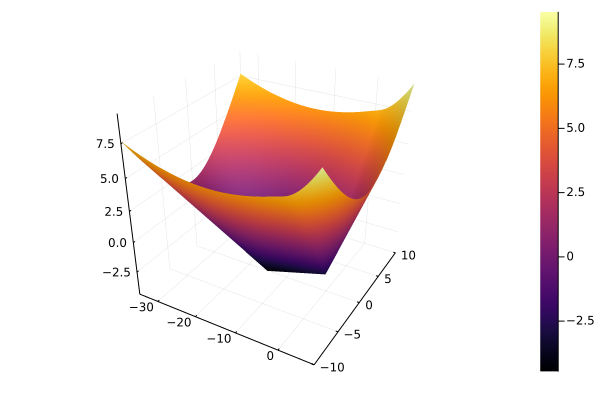

In [54]:
@time surface(x_range, y_range, f_range)

In [55]:
sympy.ccode(f_solved_)

"(((-f_s*(f_s - 2*f_t*m)*(pow(f_t, 2)*m/(f_s - 2*f_t*m) + x)/(pow(f_t, 2)*m) + fabs(y))*(((f_t) > 0) - ((f_t) < 0))*(((m) > 0) - ((m) < 0)) < 0) ? (\n   sqrt(pow(pow(f_t, 2)*m/(f_s - 2*f_t*m) + x, 2)*pow(pow(f_s, 2) - 2*f_s*f_t*m + pow(f_t, 2)*pow(m, 2), 2)/(pow(f_t, 2)*po" ⋯ 928 bytes ⋯ "+ f_s, 2), 2)/(pow(f_c - f_c0, 2)*pow(f_c*m + f_s, 2))) - (pow(f_c, 2)*pow(m, 2) - 2*f_c*f_c0*pow(m, 2) + 2*f_c*m*(f_c0*m + f_s) + pow(f_c0, 2)*pow(m, 2) - 2*f_c0*m*(f_c0*m + f_s) + pow(f_c0*m + f_s, 2))/(2*f_c*m - f_c0*m + f_s)\n)\n: (\n   -f_s + m*x + sqrt(pow(y, 2))\n)))"

In [56]:
df_dx_ = sympy.diff(f_solved_, [x, y]);

In [57]:
df_dx_a = Array([df_dx_[i] for i in [0, 1]]);

In [58]:
get_df_dx = lambdify(df_dx_a, (x, y, f_t, f_c, f_c0, f_s, m))

#122 (generic function with 1 method)

In [59]:
get_df_dx.(-36, -0, 3, 30, 22, 3, 0.1)

2-element Vector{Float64}:
 -0.7500000000000001
  0.0

In [60]:
get_df_dx.(x_range, y_range, 3, 30, 22, 3, 0.1)

300-element Vector{Vector{Float64}}:
 [-0.5005921208014331, -0.7513577798145338]
 [-0.49912348960492614, -0.7531241022220007]
 [-0.4976243536171099, -0.7549175169197724]
 [-0.49609379877281357, -0.756738587737155]
 [-0.49453087582779615, -0.7585878913311205]
 [-0.49293459873184214, -0.7604660173677597]
 [-0.4913039429156227, -0.7623735686894665]
 [-0.4896378434862913, -0.764311161465304]
 [-0.48793519332648394, -0.7662794253217273]
 [-0.4861948410910646, -0.7682790034504834]
 [-0.4844155890956135, -0.7703105526901416]
 [-0.48259619109029533, -0.7723747435772933]
 [-0.48073534991235384, -0.7744722603629902]
 ⋮
 [0.49357826018396783, 0.8414128750751376]
 [0.49832858308846645, 0.8379055908014349]
 [0.502953232293952, 0.8344444604983201]
 [0.5074565057159902, 0.8310294029143294]
 [0.5118425356890492, 0.8276602704759094]
 [0.5161152951475221, 0.8243368562932767]
 [0.520278603671423, 0.8210589005681276]
 [0.5243361333839117, 0.8178260964502239]
 [0.5282914146907776, 0.8146380953865473]
 [0.5

In [62]:
sympy.ccode(df_dx_a)

"// Not supported in C:\n// ImmutableDenseMatrix\nMatrix([\n[Piecewise(((2*f_t**2*m/(f_s - 2*f_t*m) + 2*x)*(f_s**2 - 2*f_s*f_t*m + f_t**2*m**2)**2/(2*f_t**2*(f_s - f_t*m)**2*sqrt((f_t**2*m/(f_s - 2*f_t*m) + x)**2*(f_s**2 - 2*f_s*f_t*m + f_t**2*m**2)**2/(f_t**2*(f_s - f_t*m)" ⋯ 2068 bytes ⋯ "c0)**2*(f_c*m + f_s)**2))*(2*f_c*m - f_c0*m + f_s)), (Abs(y) + (f_c0*m + f_s)*(f_c0 - m*(-f_c**2 + 2*f_c*f_c0 - f_c0**2)/(2*f_c*m - f_c0*m + f_s) + x)*(2*f_c*m - f_c0*m + f_s)/(m*(-f_c**2 + 2*f_c*f_c0 - f_c0**2)))*sign(m)*sign(-f_c + f_c0) < 0), (sqrt(y**2)/y, True))]])"